# Assignment 6 - One Body Problem

## Part A - Normal Gravity

We will integrate Newton's law of gravitational attraction using an initial time step of $dt = 1$ hour, since that seems like a reasonable amount of precision, and we integrate from $t = 0$ to $t = 1$ year. The generalized gravitational force is given as
$$
    \vec F_{grav} = -G\frac{Mm}{\|\vec r\|^{\beta}} \hat r
$$

Where $\beta \in \mathbb R$. In order to simulate normal gravity, we set $\beta = 2.0$. Equating the above to $F=m\vec a$, we get
$$
    \vec a = -G\frac{M}{\|\vec r\|^{\beta}} \hat r
$$

Now taking $\beta = 2$, since $\hat r = \frac{\vec r}{\|\vec r\|}$, and if we define $\vec r = x(t) \hat i + y(t) \hat j$, then $\vec a = \frac{d^2 }{dt^2} \vec r = \ddot x \hat i + \ddot y \hat j$, and from that, we get the following two equations that define the dynamics of our system

$$
    \boxed{\ddot x = -G\frac{Mx}{\|\vec r\|^3}  \\
    \ddot y = -G\frac{My}{\|\vec r\|^3}}
$$

The quantities we need to keep track of are position, velocity, kinentic and potential energy as functions of time. The positions and velocities can be tracked while numerically integrating the above. The potential energy can be found by integrating the force from $\infty$ to $\vec r$, and the result is simply to subtract 1 from the power of $\vec r$ in $F_{grav}$ and divide by $(\beta - 1)$, giving us
$$
    U_{grav} = -G \frac{Mm}{(\beta - 1)\|\vec r\|^{\beta-1}}
$$

And for $\beta = 2$, this gives us
$$
    U_{grav} = -G \frac{Mm}{\|\vec r\|}
$$

The kinetic energy $K$ is simply $\frac{1}2 m\|\vec v\|^2$, and thus the total energy that we get is
$$
    E_{Total} = U_{grav} + K = \frac{1}2 m\|\vec v\|^2 -G \frac{Mm}{\|\vec r\|}
$$

We can save some computational time by considering energy per unit mass, $E = \frac{E_{Total}}m$
$$
    \boxed{E = \frac{1}2 \|\vec v\|^2 -G \frac{M}{\|\vec r\|}}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# Constants required
G = 6.673e-11        # Newton's Constant in MKS units
M = 1.99e30          # The mass of the Sun in kilograms
ME = 5.97e24         # The mass of the Earth in kilograms
AU = 149597870700.0  # Earth-Sun distance in metres
yr = 365*24*60*60.0  # One year in seconds

Since mass is just a constant, we can pull it out of both. We can always scale both arrays by the mass of the planet at the end

In [3]:
def potential(rVec):
    r = np.linalg.norm(rVec)
    return -G*M/r

def kinetic(vVec):
    v = np.linalg.norm(vVec)
    return 1/2 * v**2

Acceleration defined as a function of radial position from the sun

In [4]:
def aVec(rVec):
    rx = rVec[0]
    ry = rVec[1]
    
    r = np.linalg.norm(rVec)
    
    ax = -G*M*rx/r**3
    ay = -G*M*ry/r**3
    
    return np.array([ax,ay])

## Part A - Plot the Orbit
Setting up initial values

In [5]:
ti = 0               # Initial value of time = 0
tf = 1*yr            # Final value = 1 year
dt = 1000.           # Time step = 1 hour
N  = int((tf-ti)/dt) # Number of time steps

In [6]:
r0 = 1*AU                       # Magnitude of distance from the sun
v0 = 2*np.pi*r0/yr              # Magnitude of velocity for a circular orbit
r0Vec = r0*np.array([1.0,0.0])  # The initial position vector, along x-axis
v0Vec = v0*np.array([0.0,1.0])  # The initial velcoity vector, along y-axis


rVecs = np.zeros((N+1,2),float)       # An array of 2D vectors of length N+1 for position
vVecs = np.zeros((N+1,2),float)       # An array of 2D vectors of length N+1 for velocity
t     = np.zeros(N+1,float)           # An array of length N+1 for time

rVecs[0] = r0Vec                      # Setting the initial position to r0Vec
vVecs[0] = v0Vec + aVec(rVecs[0])*dt/2 # Setting the initial velocity using the leapfrog method

Note that we will not be tracking the total energy of the system since that is just the sum of the kinetic and potential energy, so for the energy array, we can simply sum the other two arrays

In [7]:
potentialArray = np.zeros(N+1,float)
kineticArray = np.zeros(N+1, float)

potentialArray[0] = potential(r0Vec)
kineticArray[0] = kinetic(v0Vec)

In [8]:
for i in range(1,N):
    t[i] = i*dt
    rVecs[i] = rVecs[i-1] + vVecs[i-1] * dt
    vVecs[i] = vVecs[i-1] + aVec(rVecs[i]) * dt
    
    ### Conserved Quantities
    potentialArray[i] = potential(rVecs[i])
    kineticArray[i] = kinetic(vVecs[i])

### Parametric plot of orbit

Text(0, 0.5, 'y(t)')

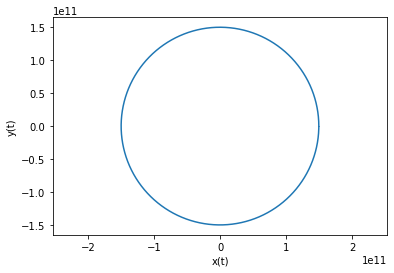

In [9]:
# Get the first and second axis of the r array
xArray = rVecs[:-1,0]
yArray = rVecs[:-1,1]

orbit_fig, orbit_ax = plt.subplots()
orbit_ax.axis('equal')
orbit_ax.plot(xArray,yArray)
orbit_ax.set_xlabel('x(t)')
orbit_ax.set_ylabel('y(t)')

### Plotting kinetic, potential and total energy

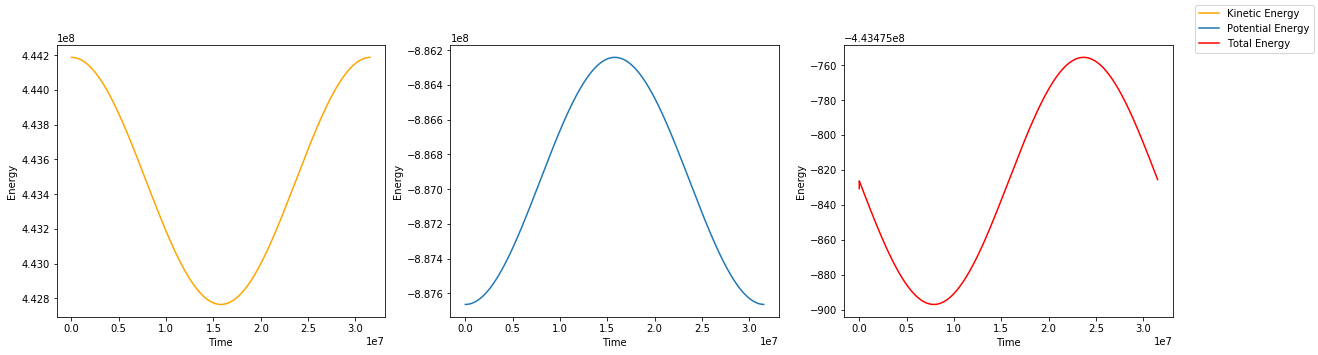

In [10]:
energy_fig, ax_array = plt.subplots(1,3)
energyArray = potentialArray + kineticArray

for ax in ax_array:
    ax.set_xlabel('Time')
    ax.set_ylabel('Energy')

KE_ax, PE_ax, TE_ax = ax_array    
energy_fig.set_size_inches((20,5))

PE_ax.plot(t[:-1], potentialArray[:-1], label="Potential Energy")
KE_ax.plot(t[:-1], kineticArray[:-1], label="Kinetic Energy", color='orange')
TE_ax.plot(t[:-1], energyArray[:-1], label="Total Energy", color='red')
energy_fig.legend()

## Part B - Optimize $dt$

To start with, let's run our simulation with various time steps. For this, a simulation class might be more appropriate as defined below. The details of how it's defined are not particularly important, since all it does is what our code above does just all contained in one object whose parameters I can vary and re-run the simulation.

In [11]:
class OneBodyOrbit(object):
    # Define Global Parameters
    G = 6.673e-11        # Newton's Constant in MKS units
    M = 1.99e30          # The mass of the Sun in kilograms
    ME = 5.97e24         # The mass of the Earth in kilograms
    AU = 149597870700.0  # Earth-Sun distance in metres
    yr = 365*24*60*60.0  # One year in seconds
    

    def __init__(self, r0 = np.array([AU,0]), v0 = np.array([0, 2*np.pi*AU/yr]), ti=0, tf=1*yr, dt=1000.):
        """
        Initialize simulation data structures
        %param r0 - Initial position, type [x, y]
        %param v0 - Initial velocity, type [x, y]
        %param ti - Initial time, type float
        %param tf - Final time, type float
        %param dt - Time step (default 1 hour), type float
        """
      
        self.r0Vec = r0
        self.v0Vec = v0
        
        self.ti = ti
        self.tf = tf
        self.dt = dt
        
        # Call the init function defined as a private function
        # so that we can reset the simulation without needing to create
        # a new instance of the class
        self._reinit_config()
    
    def _reinit_config(self):
        """
        Scope: Private
        Re-initialize configuration parameters
        """
        self.N = int((self.tf-self.ti)/self.dt)
        self.rVecs = np.zeros((self.N+1,2), float)
        self.vVecs = np.zeros((self.N+1,2), float)
        self.t = np.zeros(self.N+1,float)
        self.potentialArray = np.zeros(self.N+1,float)
        self.kineticArray = np.zeros(self.N+1, float)

        
        # Initialize arrays using the leapfrog method
        self.rVecs[0] = self.r0Vec
        self.vVecs[0] = self.v0Vec + self.aVec(rVecs[0]) * self.dt/2
        
        # Initial potential and kinetic energies
        self.potentialArray[0] = self.potential(self.r0Vec)
        self.kineticArray[0] = self.kinetic(self.v0Vec)

    def run(self, reinit=False):
        """
        Runs the simulation and returns the array of position and velocity vectors
        along with corresponding time array
        
        %param reinit - reinitialize configuration parameters
        """
        if reinit:
            self._reinit_config()
        
        for i in range(1,self.N):
            self.t[i] = i*self.dt
            self.rVecs[i] = self.rVecs[i-1] + self.vVecs[i-1] * self.dt
            self.vVecs[i] = self.vVecs[i-1] + self.aVec(self.rVecs[i]) * self.dt

            ### Conserved Quantities
            self.potentialArray[i] = self.potential(self.rVecs[i])
            self.kineticArray[i] = self.kinetic(self.vVecs[i])
        
        return self.rVecs, self.vVecs, self.t
    
    def plot_orbit(self):
        """
        Plot the orbit as a parametric function r(t)
        and return the figure and axes to the user
        """
        # Get the first and second axis of the r array
        xArray = self.rVecs[:-1,0]
        yArray = self.rVecs[:-1,1]

        orbit_fig, orbit_ax = plt.subplots()
        orbit_ax.axis('equal')
        orbit_ax.plot(xArray,yArray)
        orbit_ax.set_xlabel('x(t)')
        orbit_ax.set_ylabel('y(t)')
        return orbit_fig, orbit_ax
    
    def plot_energy(self):
        """
        Plot the energy arrays and the total energy and
        return the figure and axes to the user
        """
        energy_fig, ax_array = plt.subplots(1,3)
        energyArray = self.potentialArray + self.kineticArray

        for ax in ax_array:
            ax.set_xlabel('Time')
            ax.set_ylabel('Energy')

        KE_ax, PE_ax, TE_ax = ax_array    
        energy_fig.set_size_inches((20,5))

        PE_ax.plot(self.t[:-1], self.potentialArray[:-1], label="Potential Energy")
        KE_ax.plot(self.t[:-1], self.kineticArray[:-1], label="Kinetic Energy", color='orange')
        TE_ax.plot(self.t[:-1], energyArray[:-1], label="Total Energy", color='red')
        energy_fig.legend()
        
        return energy_fig, ax_array
        
    def aVec(self, rVec):
        """
        Acceleration function
        """
        rx = rVec[0]
        ry = rVec[1]

        r = np.linalg.norm(rVec)

        ax = -G*M*rx/r**3
        ay = -G*M*ry/r**3

        return np.array([ax,ay])
    
    def potential(self,rVec):
        r = np.linalg.norm(rVec)
        return -G*M/r

    def kinetic(self,vVec):
        v = np.linalg.norm(vVec)
        return 1/2 * v**2
    
    @property
    def energyChange(self):
        energyArray = self.kineticArray + self.potentialArray
        return energyArray[-2] - energyArray[0]

In [12]:
S = OneBodyOrbit()

In [13]:
r, v, t = S.run()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc738789640>)

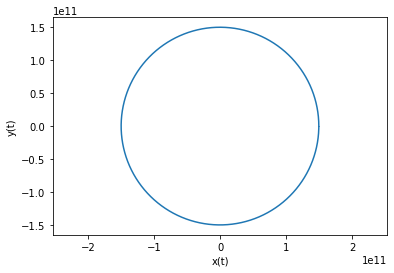

In [14]:
S.plot_orbit()

Total energy change in one orbit = 5.131681025028229


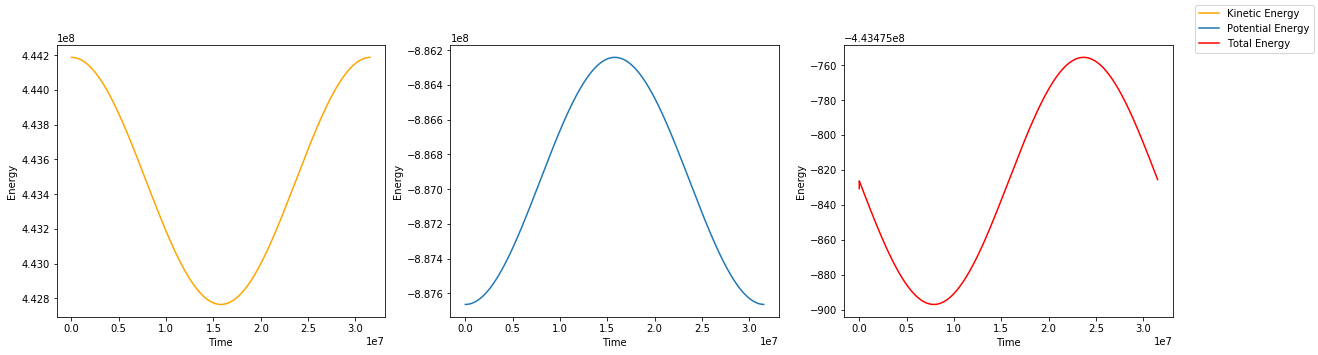

In [15]:
S.plot_energy()
print("Total energy change in one orbit =", S.energyChange)

We define a linearly spaced array of the possible values of $dt$ ranging from $1000$ to $10$ seconds. We've picked 1 hour because that's not so big (with respect to 1 year) that our simulation will be inaccurate, but not so small that our simulation takes forever to run. Along with that, we can define a function `timeit` which times our function execution. Since the return value of the simulation (the `rVec, vVec`) is not important, we can simply be concerned about the execution time.

In [16]:
def timeit(func, *args, **kwargs):
    startTime = time.time()
    func(*args, **kwargs)
    endTime = time.time()
    return endTime - startTime

In [17]:
l_lim = 10
u_lim = 1000
dtArray = np.linspace(l_lim, u_lim, 10)
deltaE = []
executionTime = []
for time_step in dtArray:
    print(time_step)
    S.dt = time_step
    executionTime.append( timeit(S.run, reinit=True) )
    deltaE.append(S.energyChange)

10.0
120.0
230.0
340.0
450.0
560.0
670.0
780.0
890.0
1000.0


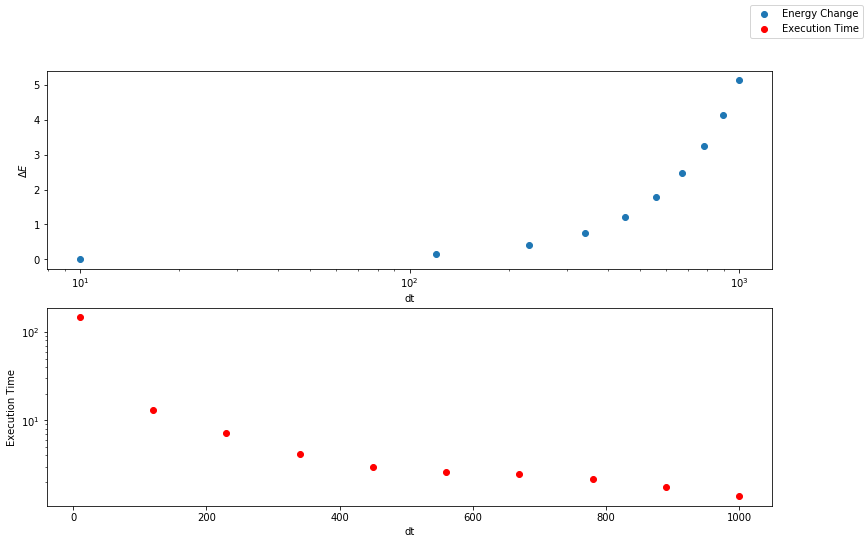

In [18]:
optimize_fig, (optimize_ax, constraint_ax) = plt.subplots(2)
optimize_fig.set_size_inches((13,8))

optimize_ax.scatter(dtArray, deltaE, label='Energy Change')
constraint_ax.scatter(dtArray, executionTime, color='red', label='Execution Time')

constraint_ax.set_xlabel('dt')
constraint_ax.set_yscale('log')
constraint_ax.set_ylabel('Execution Time')

optimize_ax.set_xscale('log')
optimize_ax.set_xlabel('dt')
optimize_ax.set_ylabel('$\Delta E$')

optimize_fig.legend()

Just eyeballing it, I'm fine with an execution time of around 10 seconds. Thus, the corresponding $dt$ would be...

In [19]:
print(dtArray[1], deltaE[1])

120.0 0.14954745769500732


120 seconds it seems. The $\Delta E$ isn't as good as I'd like it to be, but can't do more without a faster CPU. We can round it off to 100 seconds

## Part C - Kepler's Third Law

Kepler's third law states that  *the square of the orbital period of a planet is directly proportional to the cube of the semi-major axis of its orbit*. The semi-major axis is the distance between the planet and the sun, which we will take to be in astronomical units, and we can work out the period of the planet by keeping the simulation running until $\Delta E$ becomes zero  *the second time* (looking at the sinusoid for the $\Delta E$ plot above).

If we let $R$ be the semi-major axis, and $T$ be the time period, the ratio
$$
    \frac{T^2}{R^3} = k
$$
will be constant regardless of which planet we choose.

Defining the distance from the sun and the initial velocities of each planet (pulled from NASA's [planetary fact sheet](https://nssdc.gsfc.nasa.gov/planetary/factsheet/)), and running the simulation below.

In [29]:
planets = ('Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune') #Pluto's not a planet
planetDistances = np.array([57.9, 108.2, 149.6, 227.9, 778.6, 1433.5, 2872.5, 4495.1]) * 10e9 # meters
planetVelocity = np.array([47.4, 35.0, 29.8, 24.1, 13.1, 9.7, 6.8, 5.4])*1000 # m/s

In [30]:
# Sanity check that I copied everything right
if len(planets) != len(planetDistances) or len(planets) != len(planetVelocity):
    raise Exception("You've done something horribly wrong")

Yay! I haven't done anything horribly wrong!

In [57]:
def get_period(i):
    dt = 1000
    
    r0Vec = planetDistances[i]*np.array([1.0,0.0])  # The initial position vector, along x-axis
    v0Vec = planetVelocity[i] *np.array([0.0,1.0])  # The initial velcoity vector, along y-axis

    rVecs = np.array([r0Vec])
    vVecs = np.array([v0Vec])

    step_index = 1
    
    while True:
        
        rVecs = np.vstack( (rVecs, rVecs[-1] + vVecs[-1] * dt) )
        vVecs = np.vstack( (vVecs, vVecs[-1] + aVec(rVecs[-1]) * dt) )
        
        step_index += 1
        
        if step_index % 5000 == 0:
            print(step_index, rVecs[step_index-1], vVecs[step_index-1], aVec(rVecs[step_index-2]))
        
        if rVecs[-1].all() == r0Vec.all():
            return step_index * dt
        

Again, as a sanity check, we can find the orbital period of the earth, i.e, 1 year

In [58]:
get_period(planets.index('Earth'))

5000 [1.49526047e+12 1.48945691e+11] [ -295.25197198 29785.32806319] [-5.85208739e-05 -5.82820679e-06]
10000 [1.49306111e+12 2.97776405e+11] [ -582.59652779 29742.46416426] [-5.61841435e-05 -1.12042532e-05]
15000 [1.48945974e+12 4.46328703e+11] [ -855.02395168 29674.63774269] [-5.26145856e-05 -1.57653304e-05]
20000 [1.48454478e+12 5.94488995e+11] [-1107.33227757 29586.51282693] [-4.82065317e-05 -1.93034291e-05]
25000 [1.47842557e+12 7.42168932e+11] [-1336.36249905 29483.38712031] [-4.33687412e-05 -2.17702029e-05]
30000 [1.47122231e+12 8.89306681e+11] [-1540.88296534 29370.46446381] [-3.84545352e-05 -2.32437407e-05]
35000 [1.46305731e+12 1.03586508e+12] [-1721.20881649 29252.34681226] [-3.37263297e-05 -2.38780117e-05]
40000 [1.45404844e+12 1.18182790e+12] [-1878.72540037 29132.77771465] [-2.93510722e-05 -2.38554750e-05]
45000 [1.44430489e+12 1.32719533e+12] [-2015.44173923 29014.59071379] [-2.54146356e-05 -2.33533802e-05]
50000 [1.43392501e+12 1.47197960e+12] [-2133.63799446 28899.78762

KeyboardInterrupt: 

So this is strange, I was expecting this to loop around once and then return the orbital period of the earth, but from the numbers it seems like the planet is somewhere far up in the upper right location of the plot. Well, I haven't been able to solve this yet, however the question asked me to verify Kepler's third law, so I will get the values of time period again from NASA's [planetary fact sheet](https://nssdc.gsfc.nasa.gov/planetary/factsheet/) and simply plot those to show $\frac{T^2}{R^3}$ stays constant

In [62]:
timePeriods = np.array((88.0, 224.7, 365.2, 687.0, 4331, 10_747, 30_589, 59_800)) * 24 * 60 * 60 # In seconds

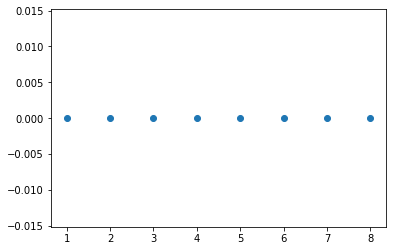

In [72]:
plt.scatter(np.arange(1,9), timePeriods**2 / planetDistances**3)    

And that's what we see. I'll keep looking into why the above code doesn't work however